# distgen/cu_inj/vcc_image

Create particles from VCC image PVs from EPICS

In [1]:
import numpy as np
import json
import os

# Nicer plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# PV data

These are the essential PVs and snapshot data needed to produce the particles.

In [2]:
PVDATA = json.load(open('CAMR-LT10-900-2021-04-08T13-10-16-07-00.json'))
PVDATA.keys()

dict_keys(['CAMR:LT10:900:Image:ArrayData', 'CAMR:LT10:900:ArraySizeX_RBV', 'CAMR:LT10:900:ArraySizeY_RBV', 'CAMR:LT10:900:RESOLUTION', 'CAMR:LT10:900:RESOLUTION.EGU'])

In [3]:
# dummy caget function
def caget(pvname):
    val = PVDATA[pvname]
    if isinstance(val, list):
        val = np.array(val)
    return(val)
def caget_many(pvlist, **kwargs):
    return [caget(pv) for pv in pvlist]

In [4]:


FACET_VCC_PV = {
    
    'array': 'CAMR:LT10:900:Image:ArrayData',
    'size_x': 'CAMR:LT10:900:ArraySizeX_RBV',
    'size_y': 'CAMR:LT10:900:ArraySizeY_RBV',
    'resolution': 'CAMR:LT10:900:RESOLUTION',
    'resolution_units': 'CAMR:LT10:900:RESOLUTION.EGU'
    
    
}

# Master dict
VCC_DEVICE_PV = {
    'CAMR:LT10:900':FACET_VCC_PV     
}

In [5]:
def get_vcc_data(vcc_device):
    # Get actual PVs
    d = VCC_DEVICE_PV[vcc_device]
    
    # Raw data
    rdata =  dict(zip(d.keys(), caget_many(d.values(), timeout=10)))
    # Make consistent units
    if rdata['resolution_units'] == 'um/px':
        rdata['resolution_units'] = 'um'
    
    data = {}    
    data['image'] = rdata['array'].reshape(rdata['size_y'], rdata['size_x'])
    for key in ['resolution', 'resolution_units']:
        data[key] = rdata[key]
        
    return data

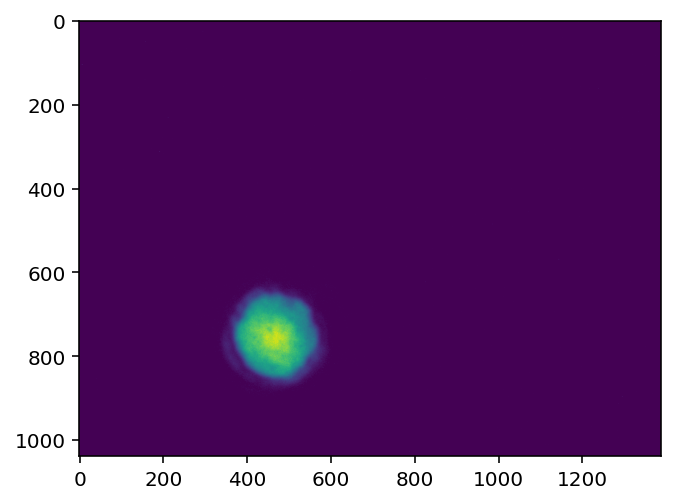

In [6]:
idata = get_vcc_data('CAMR:LT10:900')
IMAGE = idata['image']
RESOLUTION = idata['resolution']
RESOLUTION_UNITS = idata['resolution_units']
plt.imshow(IMAGE)

In [7]:
def get_live_distgen_xy_dist(filename='test.txt', vcc_device='CAMR:IN20:186'):
    
    # Get data
    dat = get_vcc_data(vcc_device)
    
    arr = dat['array']
    image = arr.reshape(dat['size_y'], dat['size_x'])
        
    cutimg = isolate_image(image)
    
    #return image, cutimg
    
    fout = write_distgen_xy_dist(filename, cutimg, dat['resolution'], resolution_units=dat['resolution_units'])
    
    return fout

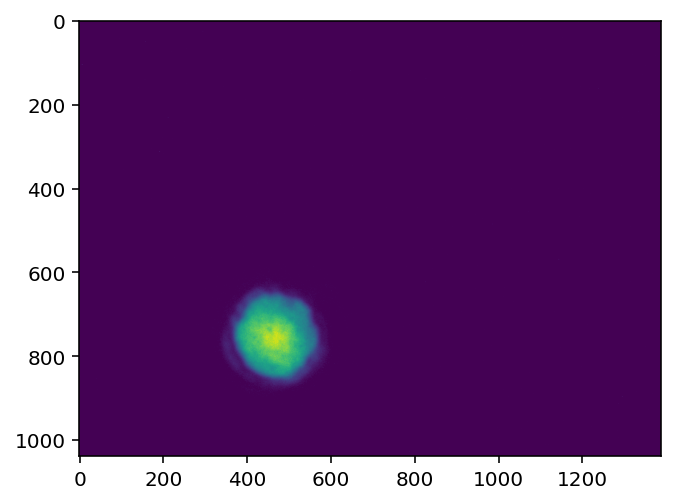

In [8]:
# The raw image
plt.imshow(IMAGE)

# Isolate the image

Region based segmentation adapted from:
https://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html

In [9]:
from skimage.filters import sobel
from skimage.util import img_as_ubyte
from skimage.segmentation import watershed
from skimage.filters.rank import median
from skimage.morphology import disk

In [10]:
def isolate_image(img):
    """
    Uses a masking technique to isolate the VCC image
    """
    img=img.copy()
    # Filter out hot pixels to use aas a mask
    # https://scikit-image.org/docs/0.12.x/auto_examples/xx_applications/plot_rank_filters.html
    img2 = median(img_as_ubyte(img), disk(1))
    
    elevation_map = sobel(img2)
    markers = np.zeros_like(img2)
    
    # TODO: tweak these numbers
    markers[img2 < .1] = 1
    markers[img2 > .2] = 2
    
    
    
    # Wateshed
    segmentation = watershed(elevation_map, markers)
    
   
    
    # Set to zero in original image
    img[np.where(segmentation != 2)]  = 0 
    
   
    
    # 
    ixnonzero0 = np.nonzero(np.sum(img2, axis=1))[0]
    ixnonzero1 = np.nonzero(np.sum(img2, axis=0))[0]
    
    i0, i1, j0, j1 = ixnonzero0[0], ixnonzero0[-1], ixnonzero1[0], ixnonzero1[-1]
    cutimg = img[i0:i1,j0:j1]
    
    return cutimg

#median(img_as_ubyte(i1), disk(1))
CUTIMG = isolate_image(IMAGE)

/Users/chrisonian/Code/miniconda3/envs/devel/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting int64 to uint8 without scaling because max value 27 fits in uint8
  return _convert(image, np.uint8, force_copy)


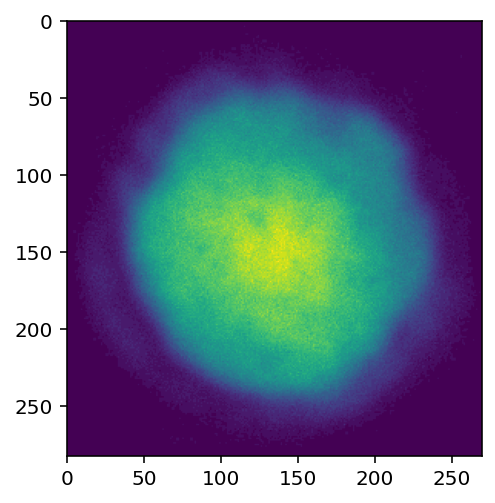

In [11]:

plt.imshow(CUTIMG)

# Create distgen xy_dist file

In [12]:
def write_distgen_xy_dist(filename, image, resolution, resolution_units='m'):
    """
    Writes image data in distgen's xy_dist format
    
    Returns the absolute path to the file written
    
    """
    
    # Get width of each dimension
    widths = resolution * np.array(image.shape)
    
    # Form header
    header = f"""x {widths[1]} {widths[1]/2} [{resolution_units}]
y {widths[0]} {widths[0]/2}  [{resolution_units}]"""
    
    # Save with the correct orientation
    np.savetxt(filename, np.flip(image, axis=0), header=header, comments='')
    
    return os.path.abspath(filename)

In [13]:
FOUT = write_distgen_xy_dist('laser_image.txt', CUTIMG, RESOLUTION, resolution_units=RESOLUTION_UNITS)

# Run distgen

In [14]:
from distgen import Generator

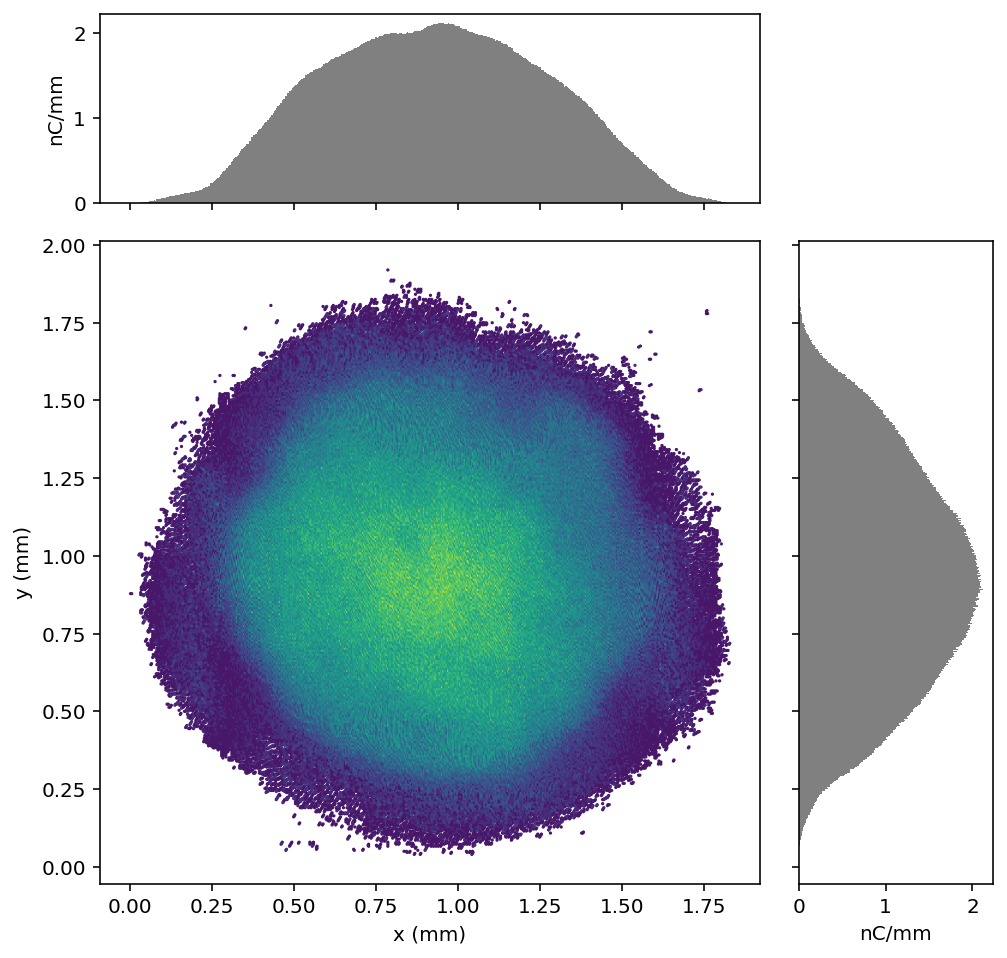

In [15]:
G = Generator('distgen.yaml')
G.run()
P = G.particles
P.plot('x', 'y', figsize=(8,8))

# Optional - Acquire from EPICS

In [ ]:
from epics import caget
import datetime

"""UTC to ISO 8601 with Local TimeZone information without microsecond"""
def isotime():
    return datetime.datetime.utcnow().replace(tzinfo=datetime.timezone.utc).astimezone().replace(microsecond=0).isoformat()   

In [ ]:
BASEPV = 'CAMR:IN20:186'

FACET_VCC_PV = {
    
    'array': 'CAMR:LT10:900:Image:ArrayData',
    'size_x': 'CAMR:LT10:900:ArraySizeX_RBV',
    'size_y': 'CAMR:LT10:900:ArraySizeY_RBV',
    'resolution': 'CAMR:LT10:900:RESOLUTION',
    'resolution_units': 'CAMR:LT10:900:RESOLUTION.EGU'
    
    
}

dat = epics.caget_many(FACET_VCC_PV.values(), timeout=10)
PVDATA = dict(zip(FACET_VCC_PV.values(), dat))
for k in ['CAMR:LT10:900:Image:ArrayData']:
    PVDATA[k] = PVDATA[k].tolist()

In [ ]:
FNAME = f'{BASEPV}-{ISOTIME}.json'
json.dump(PVDATA, open(FNAME, 'w'))
FNAME